# BirdBrain Data Wrangling and EDA

## Data Source:
ImageNet for transfer learning https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description

Kaggle Dataset: https://www.kaggle.com/gpiosenka/100-bird-species

## Problem Statement:
How can we identify the images of birds and the bird species with increasing photograph sets
produced by the current bird camera and the 5 to be added to the network?

In [1]:
#!pip3 install pydot

In [2]:
#imports
import os
from os.path import exists
import sys
import time
import numpy as np
from typing import Any, List, Tuple, Union
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage import io
from skimage import data
from skimage.util import compare_images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2S, EfficientNetV2B0
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
import pickle


tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

#Use this to check if the GPU is configured correctly
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7187620990698314923
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5769199616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15415404445310358729
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
#constants
PROJECT_DATA_PATH = './Data/'
#image expected size
#IMAGE_HEIGHT = 224 #b0
#IMAGE_WIDTH = 224 #b0
IMAGE_HEIGHT = 480 #l
IMAGE_WIDTH = 480 #l

modelname = "EfficientNetV2L"

In [4]:
#helper functions
def imageSizedCorrectly(expectedHeight, expectedWidth, imagedata):
    if imagedata.shape[0] == expectedHeight and imagedata.shape[1] == expectedWidth and imagedata.shape[2] > 1:
        return True
    return False

def getImageData(imagePath):
    if exists(imagePath):
        return io.imread(imagePath)

def loadFilePointers(csvPath, dataset):
    if not exists(csvPath):
        raise Exception('File Not Found: ' + csvPath)
    csv = pd.read_csv(csvPath)
    return csv[csv["data set"] == dataset]
    
def showDuplicateImages(set1ImagePaths, set2ImagePaths):
    for idx in range(0, len(set1ImagePaths)):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(idx+1, idx+2, 1)
        imgplot1 = plt.imshow(mpimg.imread(set1ImagePaths[idx]))
        ax1.set_title(set1ImagePaths[idx])
        ax2 = fig.add_subplot(idx+1, idx+2, 2)
        imgplot2 = plt.imshow(mpimg.imread(set2ImagePaths[idx]))
        ax2.set_title(set2ImagePaths[idx])
        plt.show()
        
def remove_bad_images(folder_path):
    num_skipped = 0
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
            print(f'Removed: {fpath}')
    if num_skipped > 0:
        print(f'Total Removed: {num_skipped}')


In [5]:
for subdirs, dirs, files in os.walk(PROJECT_DATA_PATH + "train"):
    for subdir in dirs:
        remove_bad_images(os.path.join(PROJECT_DATA_PATH + "train", subdir))
        
for subdirs, dirs, files in os.walk(PROJECT_DATA_PATH + "valid"):
    for subdir in dirs:
        remove_bad_images(os.path.join(PROJECT_DATA_PATH + "valid", subdir))

for subdirs, dirs, files in os.walk(PROJECT_DATA_PATH + "test"):
    for subdir in dirs:
        remove_bad_images(os.path.join(PROJECT_DATA_PATH + "test", subdir))
print('done!')

done!


__Set up training and validation sets and load the lables__

In [6]:
image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PROJECT_DATA_PATH + "train",
    labels='inferred',
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PROJECT_DATA_PATH + "valid",
    labels='inferred',
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

num_classes = train_ds.element_spec[1].shape[1]
print(f'Train has {num_classes} classes.')


labels = os.listdir(PROJECT_DATA_PATH + 'valid')

Found 47332 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.
Train has 325 classes.


__Helper classes for training only__

In [7]:
class Logger(object):
    """Redirect stderr to stdout, optionally print stdout to a file, and 
    optionally force flushing on both stdout and the file."""

    def __init__(self, file_name: str = None, file_mode: str = "w", should_flush: bool = True):
        self.file = None

        if file_name is not None:
            self.file = open(file_name, file_mode)

        self.should_flush = should_flush
        self.stdout = sys.stdout
        self.stderr = sys.stderr

        sys.stdout = self
        sys.stderr = self

    def __enter__(self) -> "Logger":
        return self

    def __exit__(self, exc_type: Any, exc_value: Any, traceback: Any) -> None:
        self.close()

    def write(self, text: str) -> None:
        """Write text to stdout (and a file) and optionally flush."""
        if len(text) == 0: 
            return

        if self.file is not None:
            self.file.write(text)

        self.stdout.write(text)

        if self.should_flush:
            self.flush()

    def flush(self) -> None:
        """Flush written text to both stdout and a file, if open."""
        if self.file is not None:
            self.file.flush()

        self.stdout.flush()

    def close(self) -> None:
        """Flush, close possible files, and remove stdout/stderr mirroring."""
        self.flush()

        # if using multiple loggers, prevent closing in wrong order
        if sys.stdout is self:
            sys.stdout = self.stdout
        if sys.stderr is self:
            sys.stderr = self.stderr

        if self.file is not None:
            self.file.close()


class tfModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)
    
        # Also save the optimizer state
        filepath = self._get_file_path(epoch, batch=None, logs=logs)
        filepath = filepath.rsplit( ".", 1 )[ 0 ] 
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
            pickle.dump(
            {
              'opt': model.optimizer.get_config(),
              'epoch': epoch+1
             # Add additional keys if you need to store more values
            }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizaer to %s' % (epoch + 1, filepath))


__model loading helpers...__

In [8]:
#image augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
#model building
def make_model(input_shape, num_classes):
    base = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=input_shape, classifier_activation="softmax") #keras.Input(shape=input_shape)
    model = models.Sequential()
    model.add(base)
    model.add(layers.GlobalMaxPooling2D(name="gap"))
    #model.add(data_augmentation)
    #avoid overfitting
    model.add(layers.Dropout(0.2, name="dropout_out"))
    # Set NUMBER_OF_CLASSES to the number of your final predictions.
    model.add(layers.Dense(num_classes, activation="softmax", name="fc_out"))
    base.trainable = False
    return 0, model, keras.optimizers.Adam(1e-3).get_config()

def load_model_data(model_path, opt_path):
    model = load_model(model_path)
    with open(opt_path, 'rb') as fp:
      d = pickle.load(fp)
      epoch = d['epoch']
      opt = d['opt']
      return epoch, model, opt
    
def train_model(model, initial_epoch=0, max_epochs=50):
    start_time = time.time()
    
    callbacks = [
        tfModelCheckpoint(
            os.path.join(PROJECT_DATA_PATH + f'models/{modelname}', 'model-{epoch:02d}-{val_loss:.2f}.hdf5'),
            monitor='val_loss',verbose=0),
    ]
    
    model.fit(
        train_ds,
        epochs=max_epochs,
        initial_epoch = initial_epoch,
        callbacks=callbacks,
        validation_data=val_ds,
    )

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(elapsed_time))
    

In [25]:
load_from = ''
if exists(PROJECT_DATA_PATH + f"models/{modelname}"):
    for subdirs, dirs, files in os.walk(PROJECT_DATA_PATH + f"models/{modelname}"):
        for file in files:
            if '.hdf5' in file:
                load_from = file
else:
    os.mkdir(PROJECT_DATA_PATH + f"models/{modelname}")
    
#load model if found else start a new training
if load_from == '':
    epoch, model, opt = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=num_classes)
else:
    model_path = PROJECT_DATA_PATH + f'models/{modelname}/{load_from}'
    print(model_path)
    opt_path = model_path.rsplit( ".", 1 )[ 0 ] 
    opt_path += ".pkl"
    print(opt_path)
    epoch, model, opt = load_model_data(model_path, opt_path)

./Data/models/EfficientNetV2L/model-50-3.22.hdf5
./Data/models/EfficientNetV2L/model-50-3.22.pkl


In [26]:

#keras.utils.plot_model(model, show_shapes=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam.from_config(opt),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [11]:
if not exists(PROJECT_DATA_PATH + "logs"):
    os.mkdir(PROJECT_DATA_PATH + "logs")
maxEpochs = 51
if epoch < maxEpochs:
    with Logger(os.path.join(PROJECT_DATA_PATH + 'logs', 'log.txt')):
        train_model(model, initial_epoch=epoch, max_epochs=maxEpochs)
else:
    print(f'Already trained to {epoch} epochs.')

Epoch 51/51
1480/1480 [==============================] - ETA: 0s - loss: 5.4776 - accuracy: 0.7173
Epoch 00051: saving optimizaer to ./Data/models/EfficientNetV2L\model-51-3.48.pkl
1480/1480 [==============================] - 1458s 973ms/step - loss: 5.4776 - accuracy: 0.7173 - val_loss: 3.4823 - val_accuracy: 0.7858
Elapsed time: 1458.041610956192


In [12]:
def predict(img_array):
    predictions = model.predict(img_array)
    label = 'huh'
    idx = 0
    for x in predictions[0]:
        if x > 0.8:
            score = x
            break
        idx = 1+idx
    label = labels[idx]
    #print(f"This image is {score*100} percent confidence is a(n) {label}.")
    return label, round(score*100, 2)

In [27]:
img = keras.preprocessing.image.load_img(
    PROJECT_DATA_PATH + "test/BELTED KINGFISHER/4.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

label, score = predict(img_array)
print(f"This image is {score} percent confidence is a(n) {label}.")

This image is 100.0 percent confidence is a(n) BELTED KINGFISHER.


## Well that works against the data set now let's look at live images from the backyard.

In [28]:
img = keras.preprocessing.image.load_img(
    PROJECT_DATA_PATH + "BlackCapChickadee.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

label, score = predict(img_array)
print(f"This image is {score} percent confidence is a(n) {label}.")

This image is 100.0 percent confidence is a(n) BLACK-CAPPED CHICKADEE.


### I think it is getting confused by the backgroung or foreground (there is a string or something that has faded over time to attract humming birds)

In [29]:
#object detection so we can then subset the data down to just the pixels with the bird for comparing.
import pathlib
import PIL
import numpy


In [30]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    
    if os.path.exists(os.path.expanduser('~') + '/.keras/datasets/' + model_name):
        return os.path.expanduser('~') + '/.keras/datasets/' + model_name
    else:
        model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
        return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
print(PATH_TO_MODEL_DIR)

C:\Users\tinma/.keras/datasets/centernet_hg104_1024x1024_coco17_tpu-32


In [31]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    
    if os.path.exists(os.path.expanduser('~') + '/.keras/datasets/' + filename):
        return os.path.expanduser('~') + '/.keras/datasets/' + filename
    
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)
print(PATH_TO_LABELS)

C:\Users\tinma/.keras/datasets/mscoco_label_map.pbtxt


In [32]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

print(f'Saved at: {PATH_TO_SAVED_MODEL}')

Loading model...

Done! Took 32.97739863395691 seconds
Saved at: C:\Users\tinma/.keras/datasets/centernet_hg104_1024x1024_coco17_tpu-32/saved_model


In [33]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [34]:
def find(image_np):
    
    imgHeight = image_np.shape[0]
    imgWidth = image_np.shape[1]

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
        
    image_np_with_detections = viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.60,
      agnostic_mode=False)
    
    possible_idx = []
    
    for idx in range(0, len(detections['detection_scores'])):
        if detections['detection_scores'][idx] > .75:
            (ymin, xmin, ymax, xmax) = detections['detection_boxes'][idx]
            possible_idx.append({'Class': category_index[detections['detection_classes'][idx]]['name'], 'Score': round(detections['detection_scores'][idx]*100), 'Location': (round(ymin * imgHeight), round(xmin * imgWidth), round(ymax * imgHeight), round(xmax * imgWidth))})
    
    for possible in possible_idx:
        if possible['Class'] == 'bird':
            just_bird = image_np[possible['Location'][0]:possible['Location'][2], possible['Location'][1]:possible['Location'][3]]
            im = PIL.Image.fromarray(numpy.uint8(just_bird)).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
            img_array = keras.preprocessing.image.img_to_array(im)
            img_array = tf.expand_dims(im, 0)  # Create batch axis
            label, score = predict(img_array)
            possible['Species'] = label
            possible['Probablity'] = score
    plt.figure()
    plt.imshow(image_np_with_detections)
    plt.show()    
    return {'ImageWithBoxes': image_np_with_detections, 'Predictions' : possible_idx, 'detections': detections}

Running inference for ./Data/test/BELTED KINGFISHER/4.jpg... 


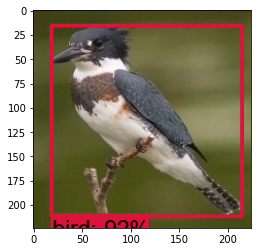

BELTED KINGFISHER with a probablity of 99.98 at (17, 18, 212, 215).

Done
Running inference for ./Data/BlackCapChickadee.jpg... 


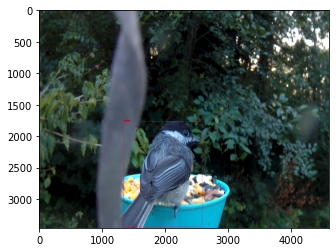

BLACK-CAPPED CHICKADEE with a probablity of 100.0 at (1768, 1346, 3436, 2593).

Done
Running inference for ./Data/20200811_184908A.jpg... 


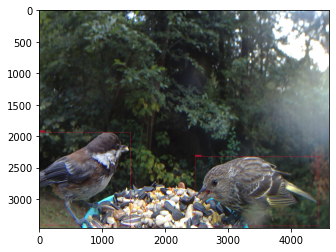

PURPLE FINCH with a probablity of 99.88 at (2325, 2480, 3421, 4447).

BLACK-CAPPED CHICKADEE with a probablity of 100.0 at (1939, 0, 3409, 1453).

Done


In [35]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
IMAGE_PATHS = [PROJECT_DATA_PATH + "test/BELTED KINGFISHER/4.jpg", PROJECT_DATA_PATH + "BlackCapChickadee.jpg", PROJECT_DATA_PATH + "20200811_184908A.jpg"]
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='\r\n')
    imgNP = load_image_into_numpy_array(image_path)
    found = find(imgNP)
        
    for possible in found['Predictions']:
        print(f"{possible['Species']} with a probablity of {round(possible['Probablity'], 2)} at {possible['Location']}.\r\n")
    print('Done')
    

In [36]:
#now we can get bounding boxes... let's see if that improves the classification.
!pip install session_info

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [37]:
#wonderful, we can get bounding boxes and the correct species for bird found.
#next step building out the requirements.txt
import session_info
session_info.show()

__I don't think I need all of these requirements since we won't be training in the api.  And will need to add fastapi__

In [38]:
#need to create the labels file for easy loading later rather than looping through a directory structure that doesn't exist.
with open(PROJECT_DATA_PATH + 'labels.txt', 'w') as file:
    for label in labels:
        file.write(f'{label}\n')